# **Desafio ETL - TelecomX**

Este notebook faz parte do desafio proposto pela Alura, com foco na análise de evasão de clientes da empresa fictícia Telecom X. A proposta é simular o consumo de uma API, realizar o processo de ETL (Extração, Transformação e Carga) e, a partir disso, desenvolver uma análise exploratória dos dados (EDA).

O objetivo é entender o comportamento dos clientes e buscar indícios que expliquem o alto índice de cancelamentos. Esta etapa é essencial para preparar os dados e gerar insights que servirão de base para futuros modelos preditivos de churn.

---

**O que será feito aqui:**

- Coleta dos dados a partir de uma URL pública (simulando uma API)
- Limpeza e transformação dos dados com pandas
- Exploração de padrões e tendências nos dados
- Visualizações estratégicas para comunicação dos insights


In [2]:
# Bibliotecas

# Tipagem
from typing import Any, Union
from collections.abc import Callable

# Utilitários
from pathlib import Path

# Conexão com API
import requests

# Manipulação de Dados
import pandas as pd
import numpy as np
import json

# Matemática
import math

# Estatística
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.preprocessing import LabelEncoder

# Seleção de Variáveis
from sklearn.feature_selection import mutual_info_classif

In [3]:
# Configurações globais Seaborn
sns.set_theme(
    style='white', # Estilo do gráfico
    font='sans-serif', # Fonte do texto
    font_scale=1.1 # Escala da fonte
)


In [4]:
# Obtém o diretório do projeto
current_dir = Path.cwd().parent

# Define o caminho do diretório de dados brutos
raw_data_dir = current_dir / 'data' / 'raw'

# Define o caminho do diretório de dados processados
processed_data_dir = current_dir / 'data' / 'processed'

# Define o caminho do diretório de visualizações
plots_dir = current_dir / 'visualizations'

## **Extracão**

Como os dados estão em formato JSON, vamos utilizar a biblioteca `requests` para fazer uma requisição HTTP e obter os dados.

In [5]:
# URL para os dados raw
url = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json'

### **Funções auxiliares para requisição e extração**

In [6]:
# Função para obter JSON de uma URL
def get_json_from_url(url: str) -> Union[dict[str, Any], list[Any], None]:
    """
    Faz uma requisição GET para a URL fornecida e retorna o JSON obtido.
    
    :param url: URL de onde obter os dados JSON.
    :return: Dados JSON como dicionário ou lista, ou None em caso de erro.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Verifica se a requisição foi bem-sucedida
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Erro ao obter os dados: {e}")
        return None

# Função para validar JSON
def validate_json(data: Union[dict[str, Any], list[Any], None]) -> bool:
    """
    Valida se os dados JSON são um dicionário ou uma lista não vazia.
    
    :param data: Dados JSON a serem validados.
    :return: True se os dados forem válidos, False caso contrário.
    """
    if not isinstance(data, (dict, list)) or (isinstance(data, dict) and not data) or (isinstance(data, list) and not data):
        print("Dados JSON inválidos ou vazios.")
        return False
    return True

# Função para salvar JSON em arquivo
def save_json_to_file(data: Union[dict[str, Any], list[Any]], file_path: Path) -> None:
    """
    Salva os dados JSON em um arquivo, tratando exceções específicas.
    
    :param data: Dados JSON a serem salvos.
    :param file_path: Caminho do arquivo onde os dados serão salvos.
    :return: True se os dados foram salvos com sucesso, False caso contrário.
    """
    try:
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
    except (FileNotFoundError, PermissionError, IOError) as e:
        print(f"Erro ao salvar o arquivo JSON: {e}")
    else:
        print(f"Dados salvos com sucesso")


### **Realiza a requisição HTTP e extrai os dados**

In [7]:
# Fluxo de requisição e validação
telecom_json = get_json_from_url(url)

# Verifica se os dados foram obtidos e se são válidos
if telecom_json and validate_json(telecom_json):
    print("Dados obtidos e validados com sucesso.")

elif telecom_json and not validate_json(telecom_json):
    print("Dados obtidos, mas inválidos ou vazios.")

Dados obtidos e validados com sucesso.


#### **Salva o dados brutos em um arquivo JSON**

Como os dados foram obtidos com sucesso, como parte de boas práticas, vamos salvar os dados brutos em um arquivo JSON local para futuras referências e evitar dependências de rede.

In [8]:
# Salva os dados JSON em um arquivo local
raw_json_file = raw_data_dir / 'telecomx_data.json'
save_json_to_file(telecom_json, raw_json_file)

Dados salvos com sucesso


Vamos carregar os dados em um DataFrame para verificar a estrutura e os tipos de dados.

In [9]:
# Carrega os dados em um DataFrame
telecom_raw_df = pd.read_json(raw_json_file, orient='records')

# Exibe uma amostra dos dados
telecom_raw_df.sample(5)

,customerID,Churn,customer,phone,internet,account
661,0940-OUQEC,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
1428,2055-PDADH,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4265,5863-OOKCL,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'No', 'OnlineSecurity': 'N...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
6359,8741-LQOBK,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'No', 'MultipleLines': 'No ph...","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
166,0264-CNITK,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'No', 'OnlineSecurity': 'N...","{'Contract': 'Two year', 'PaperlessBilling': '..."


### **Normalização dos dados**

Como temos registro aninhados, vamos utilizar a função `json_normalize` do pandas para achatar os dados e facilitar a análise.

In [10]:
# Normaliza os dados
telecom_normalized = pd.json_normalize(telecom_json, sep='_')

# Exibe uma amostra dos dados normalizados
telecom_normalized.sample(5)

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
6822,9405-GPBBG,No,Female,0,No,No,64,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.50,7069.25
4064,5566-SOEZD,No,Male,0,Yes,Yes,27,Yes,No,Fiber optic,...,Yes,No,No,No,No,One year,Yes,Credit card (automatic),80.65,2209.75
1327,1919-RTPQD,No,Male,0,Yes,Yes,7,Yes,No,DSL,...,No,No,No,No,No,Month-to-month,No,Electronic check,44.75,333.65
2159,3018-TFTSU,Yes,Male,0,No,No,12,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,No,Bank transfer (automatic),81.70,858.6
6546,8993-IZEUX,No,Male,0,No,No,7,Yes,No,Fiber optic,...,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),69.15,488.65


In [11]:
# Info sobre o DataFrame
telecom_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   internet_InternetService   7267 non-null   object 
 10  internet_OnlineSecurity    7267 non-null   object 
 11  internet_OnlineBackup      7267 non-null   object 
 12  internet_DeviceProtection  7267 non-null   object 
 13  internet_TechSupport       7267 non-null   objec

### **Dicionário de Dados**
| Coluna                     | Tipo de Dado | Descrição                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
|----------------------------|--------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `customerID`               | string       | Identificador único do cliente.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| `Churn`                    | category       | Indica se o cliente cancelou o serviço (Yes, No).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| `customer_gender`          | category       | Gênero do cliente (Male, Female).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| `customer_SeniorCitizen`   | category        | Indica se o cliente é idoso (1) ou não (0).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| `customer_Partner`         | category       | Indica se o cliente tem parceiro(a) (Yes, No).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| `customer_Dependents`      | category       | Indica se o cliente tem dependentes (Yes, No).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| `customer_tenure`          | int64        | Número de meses que o cliente permaneceu com a empresa.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| `phone_PhoneService`       | category       | Indica se o cliente possui serviço de telefone (Yes, No).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `phone_MultipleLines`      | category       | Indica se o cliente possui múltiplas linhas telefônicas (Yes, No, No phone service).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| `internet_InternetService` | category       | Tipo de serviço de internet do cliente (DSL, Fiber optic, No).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| `internet_OnlineSecurity`  | category       | Indica se o cliente possui segurança online (Yes, No, No internet service).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| `internet_OnlineBackup`    | category       | Indica se o cliente possui backup online (Yes, No, No internet service).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| `internet_DeviceProtection`| category       | Indica se o cliente possui proteção de dispositivo (Yes, No, No internet service).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| `internet_TechSupport`     | category       | Indica se o cliente possui suporte técnico (Yes, No, No internet service).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| `internet_StreamingTV`     | category       | Indica se o cliente possui serviço de streaming de TV (Yes, No, No internet service).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| `internet_StreamingMovies` | category       | Indica se o cliente possui serviço de streaming de filmes (Yes, No, No internet service).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| `account_Contract`         | category       | Tipo de contrato do cliente (Month-to-month, One year, Two year).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| `account_PaperlessBilling` | category       | Indica se o cliente optou por cobrança sem papel (Yes, No).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| `account_PaymentMethod`    | category       | Método de pagamento do cliente (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)).                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| `account_Charges_Monthly`  | float64      | Valor cobrado mensalmente do cliente.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| `account_Charges_Total`    | float64       | Valor total cobrado do cliente desde a assinatura. Pode conter valores em branco ou inválidos.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |


Temos algumas inconsistências nos dados, tipos de dados incorretos. Vamos realizar uma **limpeza inicial** para garantir que os dados estejam prontos para análise.

## **Transformação**

In [12]:
# Cria uma cópia do DataFrame para evitar alterações no original
telecom_cleaned = telecom_normalized.copy()

In [13]:
# Amostra dos dados normalizados
telecom_cleaned.sample(5)

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
4116,5647-URDKA,No,Male,0,Yes,Yes,8,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.70,130.25
5505,7548-SEPYI,Yes,Female,0,No,No,5,Yes,No,Fiber optic,...,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,96.25,512.45
3057,4255-DDUOU,Yes,Female,0,Yes,Yes,1,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.50,20.5
5613,7665-NKLAV,No,Female,0,Yes,Yes,36,No,No phone service,DSL,...,No,Yes,Yes,No,No,Two year,No,Credit card (automatic),40.65,1547.35
4782,6551-GNYDG,No,Female,0,Yes,Yes,14,Yes,No,Fiber optic,...,No,No,No,No,Yes,Month-to-month,Yes,Bank transfer (automatic),80.90,1152.8


### **Valores nulos**

In [14]:
# Verifica valores nulos
telecom_cleaned.isnull().sum()

customerID                   0
Churn                        0
customer_gender              0
customer_SeniorCitizen       0
customer_Partner             0
customer_Dependents          0
customer_tenure              0
phone_PhoneService           0
phone_MultipleLines          0
internet_InternetService     0
internet_OnlineSecurity      0
internet_OnlineBackup        0
internet_DeviceProtection    0
internet_TechSupport         0
internet_StreamingTV         0
internet_StreamingMovies     0
account_Contract             0
account_PaperlessBilling     0
account_PaymentMethod        0
account_Charges_Monthly      0
account_Charges_Total        0
dtype: int64

### **Valores duplicados**

In [15]:
# Verifica duplicatas
telecom_cleaned.duplicated().sum()

np.int64(0)

### **Valores únicos**

Aparentemente, não temos valores nulos ou duplicados, mas e quanto às categorias únicas em colunas categóricas? Vamos verificar isso para garantir que os dados estejam consistentes.

In [16]:
# Verifica categorias únicas em colunas categóricas
telecom_cleaned.select_dtypes(include=['object']).nunique()

customerID                   7267
Churn                           3
customer_gender                 2
customer_Partner                2
customer_Dependents             2
phone_PhoneService              2
phone_MultipleLines             3
internet_InternetService        3
internet_OnlineSecurity         3
internet_OnlineBackup           3
internet_DeviceProtection       3
internet_TechSupport            3
internet_StreamingTV            3
internet_StreamingMovies        3
account_Contract                3
account_PaperlessBilling        2
account_PaymentMethod           4
account_Charges_Total        6531
dtype: int64

### **Valores únicos - Churn**

A coluna `Churn` possue três valores únicos, o que é estranho, já que ela deveria conter apenas `Yes` ou `No` vamos verificar quais são esses valores e se eles estão corretos.

In [17]:
telecom_cleaned['Churn'].value_counts()

Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

#### **Substituição de valores em branco por `NaN`**

Por que essa característica passou despercebida quando buscamos por valores nulos?
O pandas considera valores 'NaN' como nulos, mas no caso temos valores que são strings em branco. Vamos substituir esses valores por `np.nan`.

In [18]:
# Substitui valores em branco por np.nan
telecom_cleaned['Churn'] = telecom_cleaned['Churn'].replace('', np.nan)

# Verifica se a substituição foi feita corretamente
telecom_cleaned['Churn'].isnull().sum()

np.int64(224)

Vamos remover esses valores `NaN` da coluna `Churn` para evitar problemas futuros na análise.

#### **Removendo valores `NaN` da coluna `Churn`**

Remover os valores nulos da coluna `Churn` não afeta a nossa futura construção de modelos preditivos, pois a coluna `Churn` é a variável alvo que queremos prever.

In [19]:
# Remover valores NaN da coluna 'Churn' com inplace=True
# Isso modifica o DataFrame original e não retorna nada
telecom_cleaned.dropna(subset=['Churn'], inplace=True)

# Verifica se a remoção foi feita corretamente
telecom_cleaned['Churn'].isnull().sum()

np.int64(0)

### **Valores únicos para colunas categóricas**

Para adiantar nosso processo de verifição de valores únicos, vamos fazer um loop para verificar as colunas categóricas e suas categorias únicas.

In [20]:
# Cria uma lista com os nomes das colunas categóricas
# Se elas começam com 'customer', 'phone', 'internet' e 'account'
# Exclui as colunas 'account_Charges_Monthly', 'account_Charges_Total' e 'costumer_tenure'
categorical_columns = [col for col in telecom_cleaned.columns if (
    col.startswith('customer_') or
    col.startswith('phone_') or
    col.startswith('internet_') or
    col.startswith('account_')
) and col not in ('account_Charges_Monthly', 'account_Charges_Total', 'customer_tenure')]

# Verifica categorias únicas em colunas categóricas
for col in categorical_columns:
    counts = telecom_cleaned[col].value_counts()
    print(counts)
    print('\n')

customer_gender
Male      3555
Female    3488
Name: count, dtype: int64


customer_SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64


customer_Partner
No     3641
Yes    3402
Name: count, dtype: int64


customer_Dependents
No     4933
Yes    2110
Name: count, dtype: int64


phone_PhoneService
Yes    6361
No      682
Name: count, dtype: int64


phone_MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


internet_InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


internet_OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


internet_OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64


internet_DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64



Parece que além da coluna `Churn`, temos as outras colunas categóricas não possuem valores inválidos. Mas vamos verificar algumas colunas com muitos valores únicos para garantir que não haja inconsistências.

In [21]:
# Verifica a coluna 'costumer_tenure'
telecom_cleaned['customer_tenure'].value_counts().sort_index(ascending=True)

customer_tenure
0      11
1     613
2     238
3     200
4     176
     ... 
68    100
69     95
70    119
71    170
72    362
Name: count, Length: 73, dtype: int64

In [22]:
categorical_columns

['customer_gender',
 'customer_SeniorCitizen',
 'customer_Partner',
 'customer_Dependents',
 'phone_PhoneService',
 'phone_MultipleLines',
 'internet_InternetService',
 'internet_OnlineSecurity',
 'internet_OnlineBackup',
 'internet_DeviceProtection',
 'internet_TechSupport',
 'internet_StreamingTV',
 'internet_StreamingMovies',
 'account_Contract',
 'account_PaperlessBilling',
 'account_PaymentMethod']

#### **Transforma o tipo das variáveis categóricas para `pd.Categorical`**

In [23]:
# Vamos corrigir os tipos das colunas categóricas, para pd.Categorical
for col in categorical_columns:
    telecom_cleaned[col] = pd.Categorical(telecom_cleaned[col])
    
# Verifica se as colunas categóricas foram convertidas corretamente
telecom_cleaned[categorical_columns].dtypes

customer_gender              category
customer_SeniorCitizen       category
customer_Partner             category
customer_Dependents          category
phone_PhoneService           category
phone_MultipleLines          category
internet_InternetService     category
internet_OnlineSecurity      category
internet_OnlineBackup        category
internet_DeviceProtection    category
internet_TechSupport         category
internet_StreamingTV         category
internet_StreamingMovies     category
account_Contract             category
account_PaperlessBilling     category
account_PaymentMethod        category
dtype: object

### **Transforma o tipo das colunas numéricas**

Agora vamos corrigir os tipos das colunas numéricas

In [24]:
# Lista de colunas numéricas
numeric_columns = [
    'account_Charges_Monthly',
    'account_Charges_Total',
    'customer_tenure'
]

# Aplica a função pd.to_numeric para converter as colunas numéricas
for col in numeric_columns:
    telecom_cleaned[col] = pd.to_numeric(telecom_cleaned[col], errors='coerce')

# Verifica se as colunas numéricas foram convertidas corretamente
telecom_cleaned[numeric_columns].dtypes

account_Charges_Monthly    float64
account_Charges_Total      float64
customer_tenure              int64
dtype: object

### **Transforma o tipo da coluna `Churn` e `customerID`**

Agora falta apenas corrigir os tipos das colunas `Churn`e `customerID`, para `pd.Categorical` e `str`, respectivamente.

In [25]:
# Converte a coluna 'Churn' para pd.Categorical
telecom_cleaned['Churn'] = pd.Categorical(telecom_cleaned['Churn'])

# Converte a coluna 'customerID' para str
telecom_cleaned['customerID'] = telecom_cleaned['customerID'].astype(str)


In [26]:
# Verifica todos os tipos de dados do DataFrame
telecom_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customerID                 7043 non-null   object  
 1   Churn                      7043 non-null   category
 2   customer_gender            7043 non-null   category
 3   customer_SeniorCitizen     7043 non-null   category
 4   customer_Partner           7043 non-null   category
 5   customer_Dependents        7043 non-null   category
 6   customer_tenure            7043 non-null   int64   
 7   phone_PhoneService         7043 non-null   category
 8   phone_MultipleLines        7043 non-null   category
 9   internet_InternetService   7043 non-null   category
 10  internet_OnlineSecurity    7043 non-null   category
 11  internet_OnlineBackup      7043 non-null   category
 12  internet_DeviceProtection  7043 non-null   category
 13  internet_TechSupport       7043 non-nu

### **Valores nulos na coluna `account_Charges_Total`**

A conversão da coluna `account_Charges_Total` para `float` gerou valores nulos. Vamos investigar esses casos.

Vamos criar um `pd.Series` com a máscara dos valores nulos na coluna `account_Charges_Total` e usar essa máscara para filtrar o DataFrame original. Assim, podemos ver quais são os registros que possuem valores nulos nessa coluna.

In [27]:
# Filtra as linhas onde 'account_Charges_Total' é nulo
total_charges_mask = telecom_cleaned['account_Charges_Total'].isnull()

# Index
total_charges_index = telecom_cleaned[total_charges_mask].index

# Usa como mascara para olhar esses valoes no df original via index
telecom_normalized.loc[total_charges_index]

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
975,1371-DWPAZ,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,
1775,2520-SGTTA,No,Female,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,
1955,2775-SEFEE,No,Male,0,No,Yes,0,Yes,Yes,DSL,...,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,
2075,2923-ARZLG,No,Male,0,Yes,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,
2232,3115-CZMZD,No,Male,0,No,Yes,0,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,
2308,3213-VVOLG,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,
2930,4075-WKNIU,No,Female,0,Yes,Yes,0,Yes,Yes,DSL,...,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,
3134,4367-NUYAO,No,Male,0,Yes,Yes,0,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,
3203,4472-LVYGI,No,Female,0,Yes,Yes,0,No,No phone service,DSL,...,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,
4169,5709-LVOEQ,No,Female,0,Yes,Yes,0,Yes,No,DSL,...,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,


Temos o mesmo caso que vimos anteriormente, alguns valores estão originalmente em branco.

### **Cria a coluna `daily_charges`**

Por último, foi solicitado a criação de uma coluna `daily_charges`, que representa o valor cobrado diariamente do cliente. Vamos criar essa coluna supondo um período de 30 dias para o cálculo.

In [28]:
days = 30  # Supondo um período de 30 dias

# Cria a coluna 'daily_charges'
# Usaremos 2 casas decimais para o valor para manter a consistência
telecom_cleaned['daily_charges'] = round(telecom_cleaned['account_Charges_Monthly'] / days, 2)

# Exibe uma amostra dos dados com a nova coluna
telecom_cleaned.sample(5)

,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total,daily_charges
4146,5685-IIXLY,Yes,Female,0,Yes,Yes,5,Yes,No,Fiber optic,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,83.60,404.20,2.79
2375,3317-HRTNN,Yes,Female,1,No,No,5,No,No phone service,DSL,...,No,No,Yes,Yes,Month-to-month,No,Electronic check,45.70,198.00,1.52
1591,2262-SLNVK,No,Female,0,No,No,1,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,No,Electronic check,70.10,70.10,2.34
4359,5981-ZVXOT,No,Female,1,No,No,35,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,One year,Yes,Electronic check,108.35,3726.15,3.61
1999,2828-SLQPF,No,Male,0,No,No,19,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),45.00,865.85,1.50


### **Salva o DataFrame processado**

Depois dessas transformações podemos salvar o DataFrame limpo em um arquivo CSV na pasta para os dados processados para futuras análises e visualizações.

In [29]:
# Caminho para o arquivo CSV processado
processed_csv_file = processed_data_dir / 'telecomx_cleanned.csv'

# Salva o DataFrame
telecom_cleaned.to_csv(processed_csv_file, index=False)

## **Análise**

### **Estatísticas descritivas para as colunas categóricas**

Agora podemos partir para a análise exploratória dos dados (EDA). Vamos começar visualizando algumas estatísticas descritivas do DataFrame para entender melhor os dados.

In [30]:
# Estatísticas descritivas do DataFrame para os dados categóricos
telecom_cleaned.describe(include='category')

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,No,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,5174,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365


Analisando o resumo das variáveis categóricas, observa-se que a classe de **churn** (`Churn`) é bastante desbalanceada: a maioria dos clientes (5 174 de 7 043) não cancelou o serviço, indicando uma taxa de churn de ~26,6 %. Esse desbalanceamento deve ser considerado ao treinar modelos de classificação.  

No que diz respeito ao perfil, o **gênero** do cliente (`customer_gender`) é praticamente equilibrado, com leve predominância de clientes do sexo **masculino** (3 555 vs. 3 488), ao passo que a maior parte não é **idosa** (`customer_SeniorCitizen = 0`, 5 901 registros). Além disso, há mais clientes sem **parceiro** (`customer_Partner = No`, 3 641) e sem **dependentes** (`customer_Dependents = No`, 4 933), sugerindo um público majoritariamente sem vínculos familiares diretos.  

Em relação aos serviços, o **serviço telefônico** (`phone_PhoneService`) é adotado pela quase totalidade (6 361 “Yes”), mas a maioria não contrata **linhas múltiplas** (`phone_MultipleLines = No`, 3 390). Para o **serviço de internet**, a opção **Fiber optic** é a mais comum (3 096), e as funcionalidades adicionais—**Online Security**, **Online Backup**, **Device Protection**, **Tech Support**, **Streaming TV** e **Streaming Movies**—são majoritariamente não contratadas. 

No escopo de faturamento, o contrato **Month-to-month** domina (`account_Contract = Month-to-month`, 3 875), reforçando a tendência de clientes preferirem flexibilidade. A **fatura sem papel** (`account_PaperlessBilling = Yes`, 4 171) também é a opção majoritária, e o **método de pagamento** mais usado é o **Electronic check** (2 365), indicando uma forte adesão a cobranças digitais.


### **Estatísticas descritivas para colunas numéricas**

In [31]:
# Estatísticas descritivas do DataFrame para os dados numéricos
telecom_cleaned.describe(include='number')

,customer_tenure,account_Charges_Monthly,account_Charges_Total,daily_charges
count,7043.000000,7043.000000,7032.000000,7043.000000
mean,32.371149,64.761692,2283.300441,2.158675
std,24.559481,30.090047,2266.771362,1.003088
min,0.000000,18.250000,18.800000,0.610000
25%,9.000000,35.500000,401.450000,1.180000
50%,29.000000,70.350000,1397.475000,2.340000
75%,55.000000,89.850000,3794.737500,2.990000
max,72.000000,118.750000,8684.800000,3.960000


Ao analisar as estatísticas descritivas das variáveis numéricas, observamos o seguinte:

- **Tempo de relacionamento** (`customer_tenure`):  
  - Média de **32,37** meses, indicando que, em média, os clientes permanecem quase três anos na operadora.  
  - Mediana de **29** meses, sugerindo que metade dos clientes fica menos de 29 meses e metade fica mais.  
  - Mínimo de **0** meses (clientes recém-chegados) e máximo de **72** meses (clientes com 6 anos de relação).  
  - Desvio padrão de **24,56**, mostrando variação considerável no tempo de permanência.

- **Cobrança mensal** (`account_Charges_Monthly`):  
  - Média de **R\$ 64,76**, com mediana em **R\$ 70,35**, indicando que a maioria dos planos gira em torno dessa faixa.  
  - Valores mínimo de **R\$ 18,25** e máximo de **R\$ 118,75**, refletindo uma ampla gama de pacotes contratados.  
  - Desvio padrão de **30,09**, apontando variabilidade moderada nos valores mensais.

- **Custo total acumulado** (`account_Charges_Total`):  
  - Média de **R\$ 2 283,30**, mas mediana de **R\$ 1 397,48**, sugerindo que alguns clientes antigos ou de maior gasto elevam a média.  
  - Mínimo de **R\$ 18,80** e máximo de **R\$ 8 684,80**, refletindo clientes com poucos dias de serviço até clientes de longa data.  
  - Desvio padrão alto de **R\$ 2 266,77**, confirmando grande dispersão nos custos totais.

- **Custo diário médio** (`daily_charges`):  
  - Média de **R\$ 2,16** por dia, com mediana de **R\$ 2,34**, indicando que a maioria dos clientes gasta entre R\$ 1,80 e R\$ 3,00 diários.  
  - Mínimo de **R\$ 0,61** e máximo de **R\$ 3,96**, mostrando variação no nível de consumo diário equivalente.  
  - Desvio padrão de **1,00**, revelando moderada dispersão em torno da média diária.

Em suma, as medidas de tendência central (média e mediana) e de dispersão (desvio padrão, amplitude entre mínimo e máximo) revelam que há segmentos de clientes com perfis muito distintos — desde usuários recém-chegados e de baixo gasto até clientes de longa data com custos acumulados elevados. Essas diferenças podem orientar estratégias de retenção e segmentação de ofertas.  


### **Distribuição da variável `Churn`**

Agora vamos visualizar graficamente a distribuição da variável `Churn` para entender melhor a proporção de clientes que cancelaram o serviço.

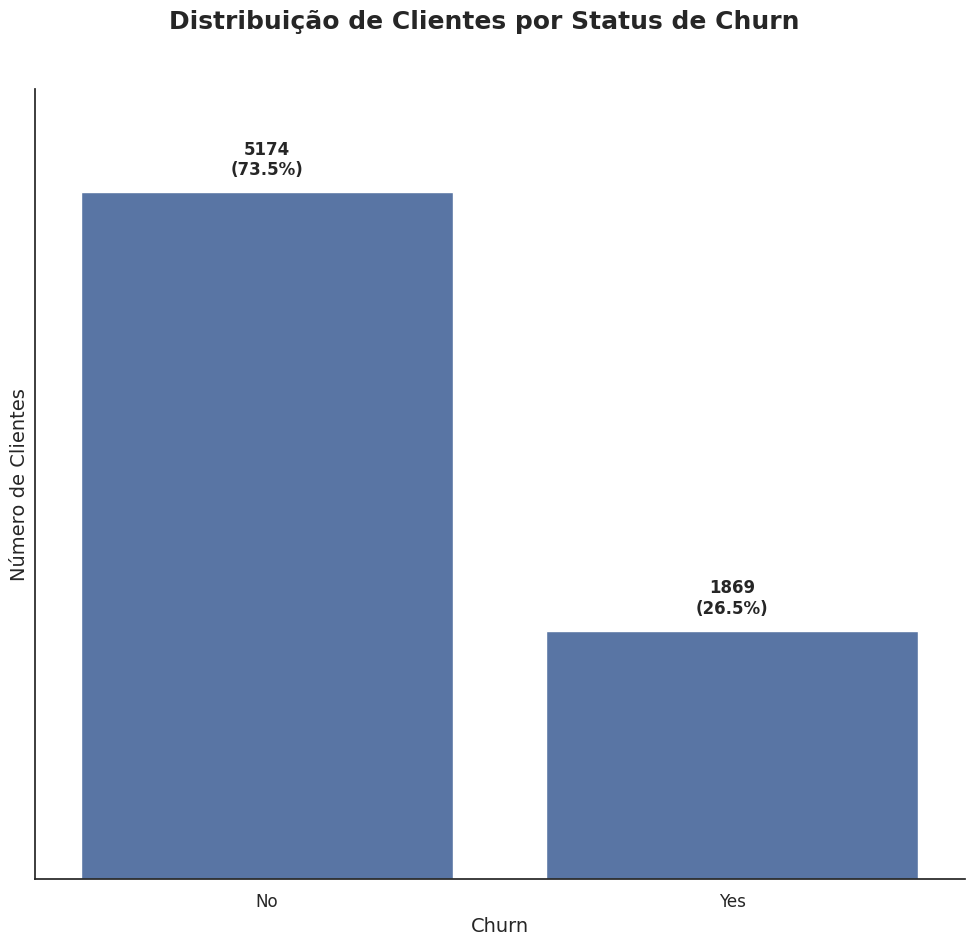

In [32]:
# Cria a figura e o eixo
fig, ax = plt.subplots(figsize=(12, 10))

# Ajusta espaço superior para o suptitle
fig.subplots_adjust(top=0.90)

# Título geral da figura
fig.suptitle('Distribuição de Clientes por Status de Churn',
             fontsize=18, fontweight='bold')

# Plota o countplot
sns.countplot(
    data=telecom_cleaned,
    x='Churn',
    order=['No', 'Yes'],
    ax=ax
)

# Rótulos dos eixos
ax.set_xlabel('Churn', fontsize=14)
ax.set_ylabel('Número de Clientes', fontsize=14)

# Remove spine superior e direita, e y-ticks
sns.despine()
ax.tick_params(axis='y', left=False, labelleft=False)
# ax.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.5)

# Garantir folga no topo para as anotações
max_height = max(p.get_height() for p in ax.patches)
ax.set_ylim(0, max_height * 1.15)

# Anotações com contagem e porcentagem
total = len(telecom_cleaned)
for p in ax.patches:
    count = int(p.get_height())
    pct = count / total * 100
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    offset = max_height * 0.02  # 2% do valor máximo
    ax.annotate(f'{count}\n({pct:.1f}%)',
                (x, y + offset),
                ha='center',
                va='bottom',
                fontsize=12,
                fontweight='semibold')

# Salva o gráfico
fig.savefig(plots_dir / 'churn_distribution.png', bbox_inches='tight', dpi=300)

# Exibe o gráfico
plt.show()


Como podemos observar, se trata de um problema de classificação desbalanceada, onde a maioria dos clientes não cancelou o serviço. Isso é comum em problemas de churn, importante ter isso em mente ao desenvolver modelos preditivos, dado que isso produz grandes impactos na performance dos modelos.

### **Explorando a relação entre `Churn` e variáveis categóricas**

Agora vamos analisar a relação entre o status de churn e outras variáveis categóricas. Vamos criar uma lista com as colunas categóricas do DataFrame, exceto a coluna `Churn` e `customerID`.

In [33]:
# Lista de colunas categóricas, desonsiderando 'Churn' e costumerID
categorical_columns = (
    telecom_cleaned
    .select_dtypes(include=['object', 'category'])
    .columns
    .difference(['Churn', 'customerID'])
    .tolist()
)

In [34]:
# Outro método para obter colunas categóricas
categorical_columns = [
    col for col in telecom_cleaned.select_dtypes(include=['object', 'category'])
    if col not in ('Churn', 'customerID')
]

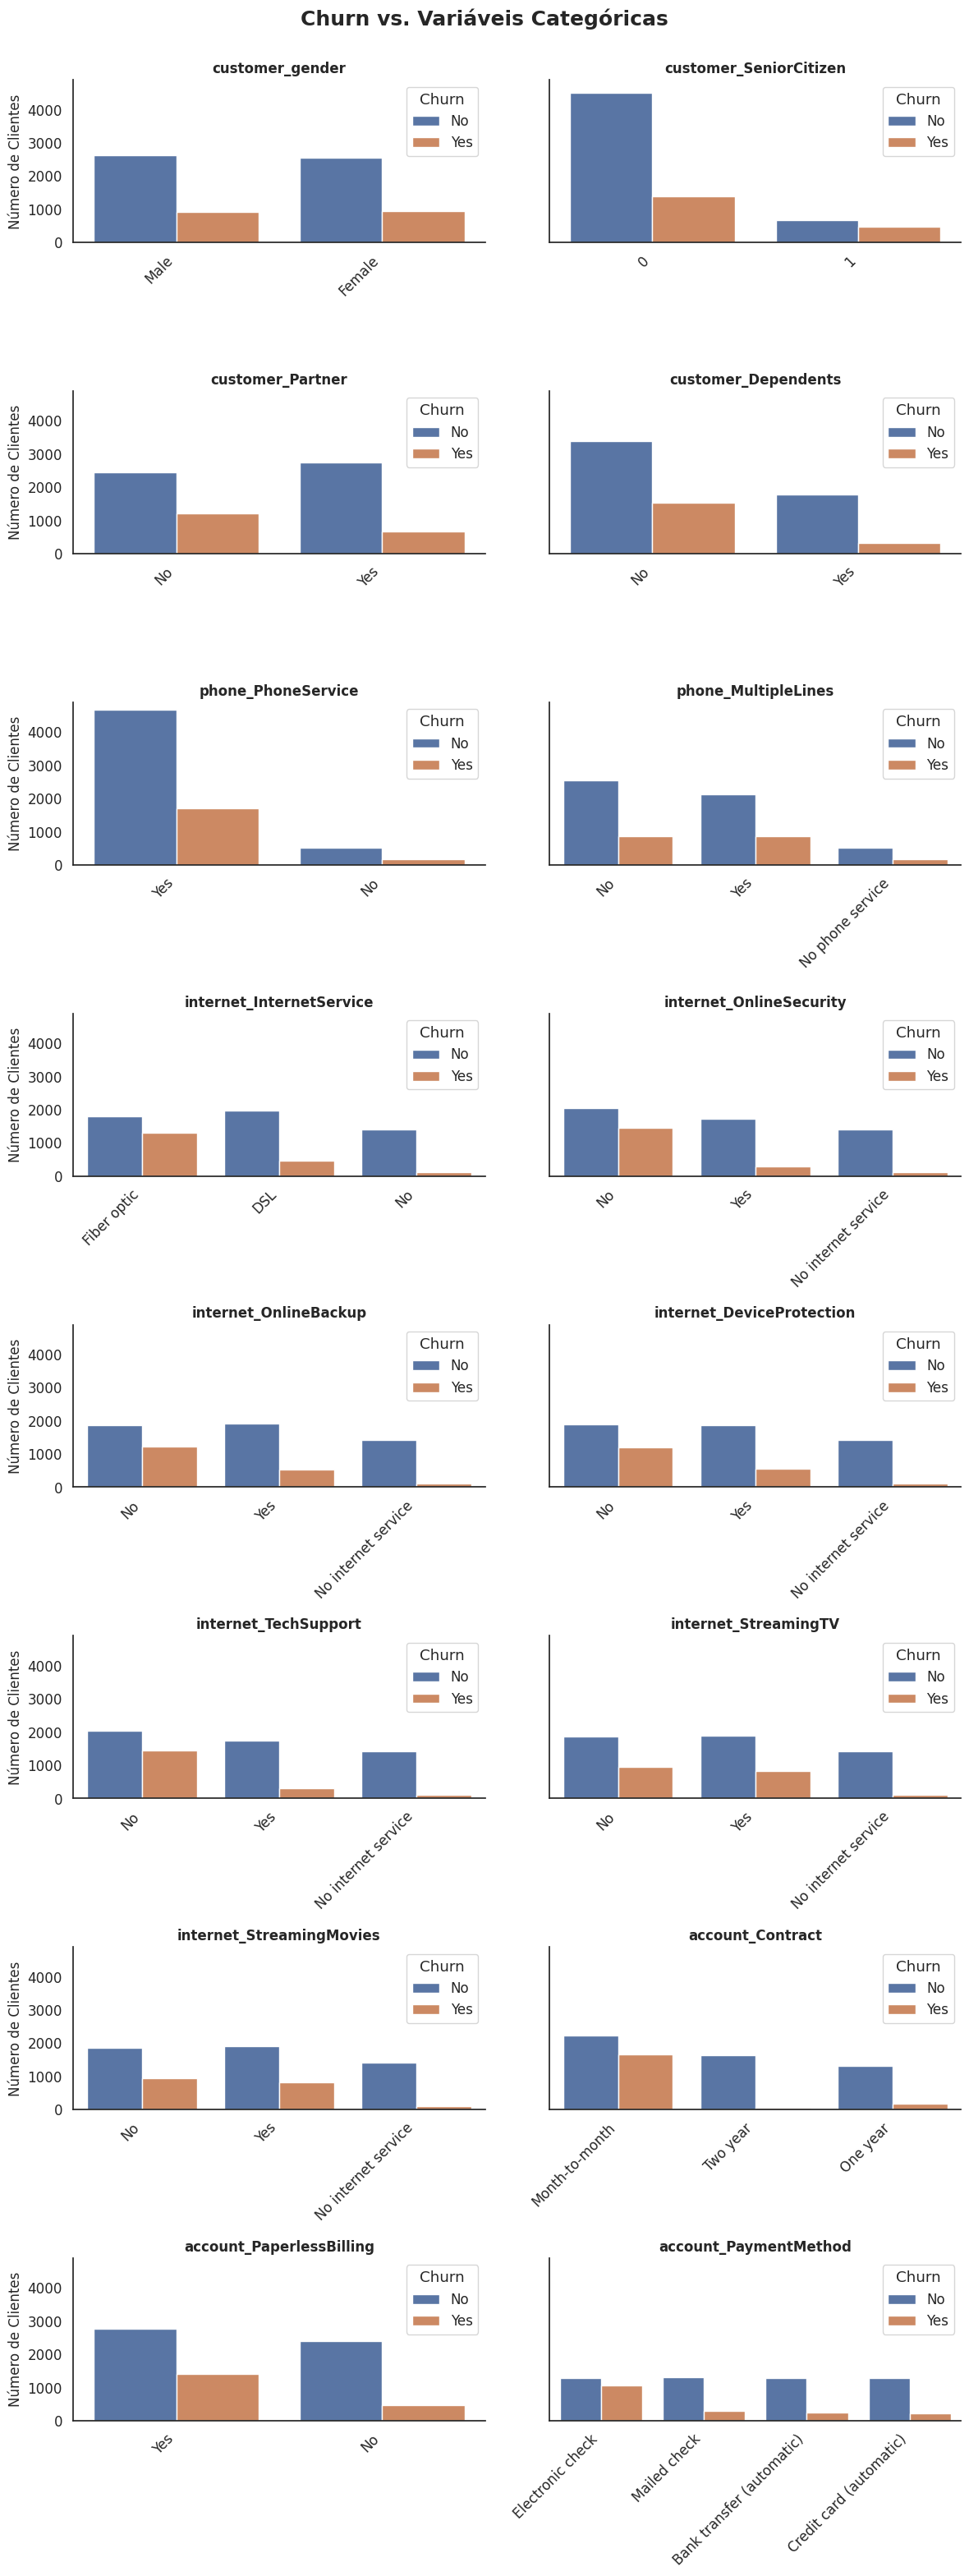

In [35]:
# Define a figura com base no número de colunas categóricas
n = len(categorical_columns)
ncols = 2
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 4),
                         sharey=True)

# Achata os eixos para facilitar o loop
axes = axes.flatten()

# Loop para plotar cada coluna categórica
for ax, var in zip(axes, categorical_columns):
    sns.countplot(
        data=telecom_cleaned,
        x=var,
        hue='Churn',
        order=telecom_cleaned[var].value_counts().index,
        ax=ax
    )
    
    # Título e rótulos dos eixos
    ax.set_title(f'{var}', fontsize=12, fontweight='bold')
    ax.set_xlabel('') # Sem rótulo no eixo x
    ax.set_ylabel('Número de Clientes', fontsize=12)
    # Rotaciona os labels para evitar sobreposição
    # Rotaciona e alinha os labels corretamente (sem warning)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')
            

    # Despine
    sns.despine(ax=ax)

# Título geral e ajuste do layout
fig.suptitle('Churn vs. Variáveis Categóricas', 
             fontsize=18, fontweight='bold', ha='center')
fig.subplots_adjust(hspace=0.5, wspace=0.3, top=0.92)


# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.98])

# Salva o gráfico
fig.savefig(plots_dir / 'churn_vs_categorical_variables.png', bbox_inches='tight', dpi=300)

# Exibe o gráfico
plt.show()


### **Explorando a relação entre `Churn` e variáveis numéricas**

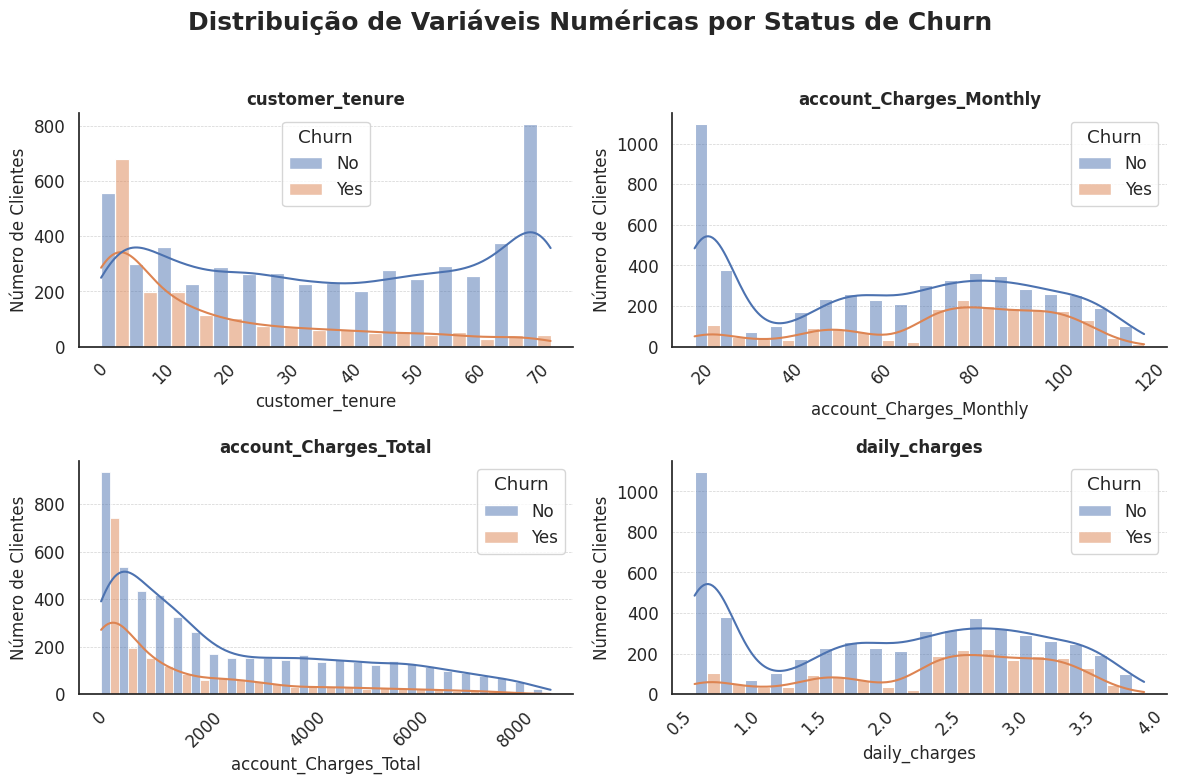

In [54]:
# Lista de variáveis numéricas
numeric_columns = telecom_cleaned.select_dtypes(include=['number']).columns.tolist()

# Define o número de colunas e linhas para os subplots
n = len(numeric_columns)
ncols = 2
nrows = math.ceil(n / ncols)

# Cria a figura
fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 4), sharey=False)

# Achata os eixos para facilitar o loop
axes = axes.flatten()

# Plota o histograma
for ax, var in zip(axes, numeric_columns):
    sns.histplot(
        data=telecom_cleaned,
        x=var,
        hue='Churn',
        kde=True,
        stat='count',
        multiple='dodge',
        common_norm=False,
        ax=ax
    )
    
    # Título e rótulos dos eixos
    ax.set_title(f'{var}', fontsize=12, fontweight='bold')
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel('Número de Clientes', fontsize=12)
    
    # Despine
    sns.despine(ax=ax)
    
# Título geral da figura
fig.suptitle('Distribuição de Variáveis Numéricas por Status de Churn', 
             fontsize=18, fontweight='bold', ha='center')

# Ajustes de layout e espaçamento
fig.subplots_adjust(hspace=0.4, wspace=0.3, top=0.92)

# Gira as labels do eixo x apenas quando necessário
for ax in axes:
    ax.tick_params(axis='x', labelrotation=45)  # se quiser girar todas
    ax.grid(axis='y', linestyle='--', linewidth=0.5, color='lightgray')

# Remove eixos não utilizados (caso número de variáveis seja ímpar)
for i in range(n, len(axes)):
    fig.delaxes(axes[i])

# Ajusta o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Salva o gráfico
fig.savefig(plots_dir / 'churn_vs_numeric_variables.png', bbox_inches='tight', dpi=300)

# Exibe o gráfico
plt.show()


Podemos observar que o `Churn` ocorre com maior frequência em clientes que possuem um tempo de contrato menor (`customer_tenure`). 

### **Explorando as correlações entre variáveis numéricas e `Churn`**

Vamos começar criando uma nova cópia do DataFrame para evitar alterações no original e, em seguida, converter a coluna `Churn` para valores numéricos (0 e 1) para facilitar a análise de correlação.

In [37]:
# Cópia do DataFrame para evitar alterações no original
telecom_correlation = telecom_cleaned.copy()

# Instância o LabelEncoder
le= LabelEncoder()

# Usa o fit_transform para converter a coluna 'Churn' em numérica
telecom_correlation['Churn'] = le.fit_transform(telecom_correlation['Churn'])

In [38]:
# Lista de colunas numéricas, incluindo 'Churn'
num_cols_to_corr = numeric_columns + ['Churn']

In [39]:
telecom_cleaned['Churn'].isnull().sum()

np.int64(0)

#### **Função para plotar matriz de correlação**

Vamos criar uma função auxiliar que recebe o DataFrame, a lista de colunas a serem correlacionadas e o método de correlação desejado. A função irá calcular a matriz de correlação e plotar um heatmap.

In [40]:
# Função wrapper para pegar apenas o primeiro valor da `pointbiserialr`
def pointbiserialr_wrapper(x, y):
    """Calcula a correlação ponto-biserial entre duas variáveis.

    Args:
        x (pd.Series): A primeira variável.
        y (pd.Series): A segunda variável (binária).

    Returns:
        float: O coeficiente de correlação ponto-biserial.
    """
    return pointbiserialr(x, y)[0]

In [41]:
# Função para plotar matriz de correlação
def plot_correlation_matrix(df: pd.DataFrame, columns: list[str],
                            method: Union[str, Callable], plots_dir: Path) -> None:
    """
    Plota a matriz de correlação para as colunas especificadas do DataFrame.
    
    :param df: DataFrame contendo os dados.
    :param columns: Lista de colunas a serem correlacionadas.
    :param method: Método de correlação a ser usado ('pearson', 'spearman', 'kendall', 'pointbiserialr').
    :param plots_dir: Diretório para salvar os gráficos.
    """
    
     # Substitui por função wrapper se for pointbiserialr
    if method == 'pointbiserialr':
        corr_func = pointbiserialr_wrapper
        method_name = 'pointbiserialr'
    else:
        corr_func = method
        method_name = method if isinstance(method, str) else method.__name__
        
    # Calcula a matriz de correlação
    corr_matrix = df[columns].corr(method=corr_func)
    
    # Cria a figura e o eixo
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Ajusta espaço superior para o suptitle
    fig.subplots_adjust(top=0.90)
    
    # Cria o heatmap
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        cbar_kws={"shrink": .8},
        linewidths=0.5,
        linecolor='black',
    )
    
    # Título do gráfico
    ax.set_title(f'Matriz de Correlação - Método: {method_name.capitalize()}',
                fontsize=18, fontweight='bold', ha='center')
    
    # Ajustes visuais
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    sns.despine(left=True, bottom=True)
    
    # Salva e exibe
    fig.savefig(plots_dir / f'correlation_matrix_{method_name}.png', dpi=300, bbox_inches='tight')

    # Exibe o gráfico
    plt.show()

#### **Correlação de Pearson**

A Correlação de Pearson mede a força e a direção da relação linear entre duas variáveis numéricas. Para um par de vetores $X = \{x_i\}$ e $Y = \{y_i\}$ de tamanho $n$, o coeficiente $r$ é dado por

$$
r = \frac{\displaystyle\sum_{i=1}^n (x_i - \bar x)\,(y_i - \bar y)}
         {\sqrt{\displaystyle\sum_{i=1}^n (x_i - \bar x)^2 \;\sum_{i=1}^n (y_i - \bar y)^2}}
$$

onde $\bar x$ e $\bar y$ são as médias de $X$ e $Y$.


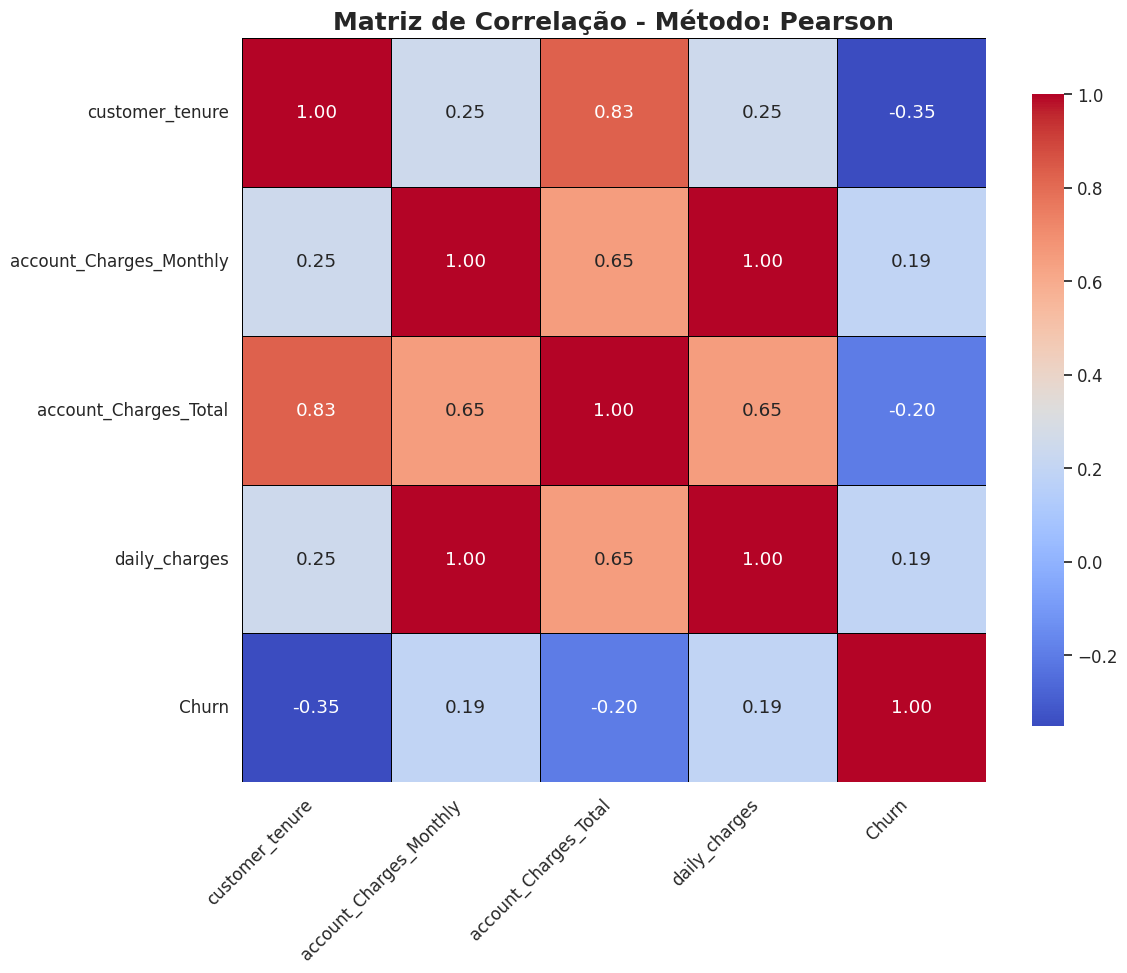

In [42]:
# Plotar a matriz de correlação para Pearson
plot_correlation_matrix(telecom_correlation, num_cols_to_corr, 'pearson', plots_dir)

#### **Correlação de Ponto-Bisserial**

Dados uma variável $X$ contínua e $Y \in \{0,1\}$, o coeficiente Ponto-Bisserial $r_{pb}$ é dado por:

$$
r_{pb} = \frac{\bar{X}_1 - \bar{X}_0}{s_{n-1}}\,\sqrt{\frac{n_1\,n_0}{n\,(n-1)}}
$$

onde  
- $\bar{X}_1$ e $\bar{X}_0$ são as médias de $X$ nos grupos $Y=1$ e $Y=0$,  
- $s_{n-1}$ é o desvio-padrão de $X$ (todas as observações),  
- $n_1$ e $n_0$ são as contagens de $Y=1$ e $Y=0$,  
- $n = n_1 + n_0$.


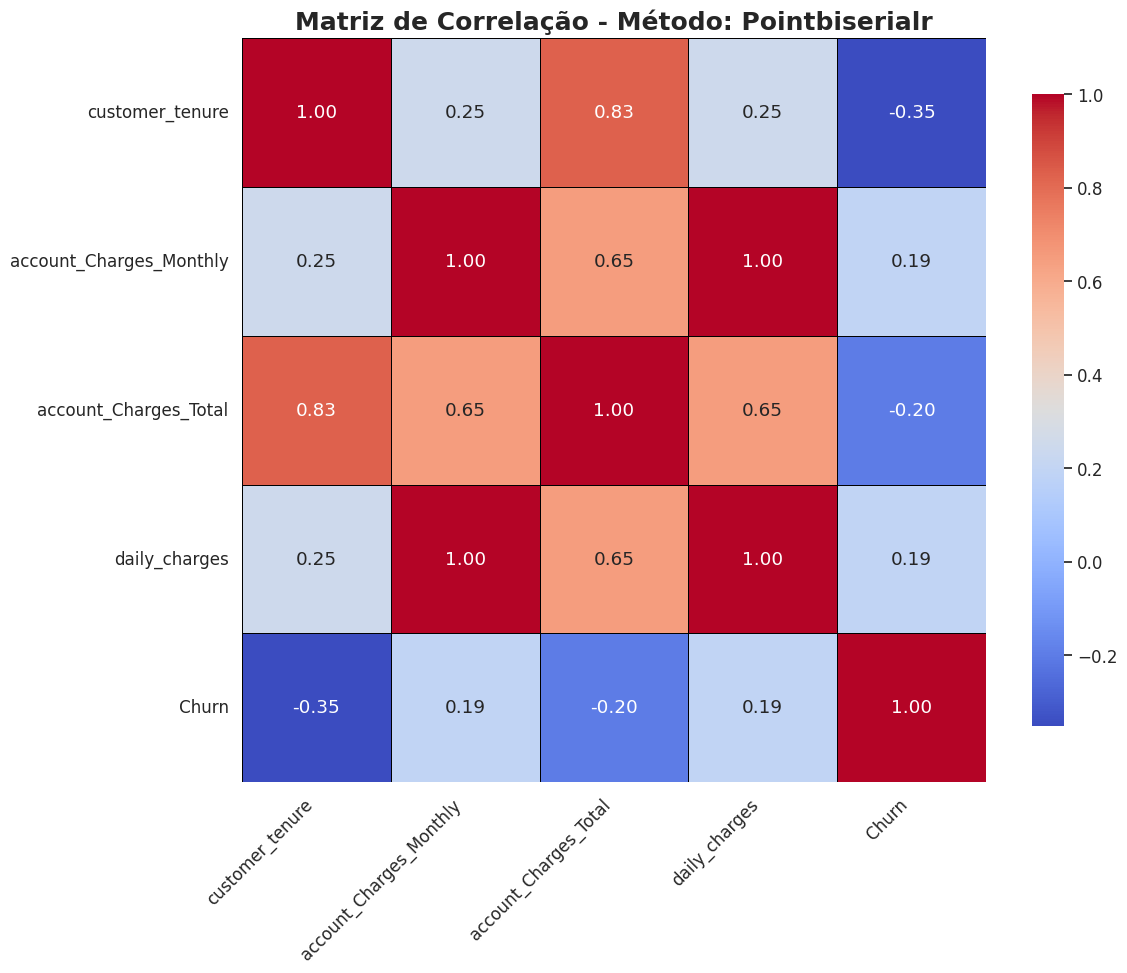

In [43]:
# Plotar a matriz de correlação para Point-Biserial
plot_correlation_matrix(telecom_correlation, num_cols_to_corr, 'pointbiserialr', plots_dir)

Ao explorar essa matriz de correlação, fica claro que a **duração do relacionamento** com o cliente `(customer_tenure)` é o maior indicador de churn negativo (≈ –0,35): quanto mais tempo o cliente permanece, menor a chance de cancelamento. Isso faz sentido intuitivo — lealdade construída ao longo do tempo tende a reduzir desistências.

Surpreende ver que **cobrança mensal** `(account_Charges_Monthly)`  e **cobrança diária** `(daily_charges)` estão quase perfeitamente alinhadas (≈ 0,999). Na prática, isso sugere que estamos medindo a mesma informação com duas variáveis; poderíamos descartar uma sem perder poder preditivo, simplificando nosso modelo.

O **custo total** do cliente `(account_Charges_Total)` também apresenta correlação negativa com churn (≈ –0,20). Clientes que acumularam maiores gastos até o momento mostraram uma propensão menor a cancelar.

Por fim, as correlações positivas moderadas de **cobrança mensal** `(account_Charges_Monthly)` e **diária** `(daily_charges)` com o churn (≈ 0,19) indicam que cobranças mais altas podem estar associadas a um leve aumento na insatisfação ou na percepção de custo elevado. Vale investigar se há um ponto de preço ótimo para equilíbrio entre receita e retenção.

Em resumo, faria sentido:
- Manter `customer_tenure` e `account_Charges_Total` como variáveis centrais na previsão de churn.  
- Avaliar remover ou agrupar `account_Charges_Monthly` e `daily_Charges` para reduzir multicolinearidade.  
- Monitorar políticas de preço para não elevar demais a percepção de custo e, assim, evitar pequenas elevações de churn.  


In [44]:
# Tabela de correlação Pearson
telecom_correlation[num_cols_to_corr].corr(method='pearson').round(2)

,customer_tenure,account_Charges_Monthly,account_Charges_Total,daily_charges,Churn
customer_tenure,1.00,0.25,0.83,0.25,-0.35
account_Charges_Monthly,0.25,1.00,0.65,1.00,0.19
account_Charges_Total,0.83,0.65,1.00,0.65,-0.20
daily_charges,0.25,1.00,0.65,1.00,0.19
Churn,-0.35,0.19,-0.20,0.19,1.00


Como era de se esperar, o coeficiente obtido pelo método de Pearson foi idêntico ao da Correlação Ponto-Bisserial. Isso acontece porque o Ponto-Bisserial nada mais é do que uma aplicação especial do Pearson quando uma das variáveis é binária, de modo que ambos retornam exatamente o mesmo valor nesse contexto.

### **Relações entre variáveis categóricas e `Churn`**

#### **Teste de Qui-quadrado para variáveis categóricas**

O que é o teste de Qui-quadrado?

O valor de $\chi^2$ vem do **teste de independência do Qui-quadrado de Pearson**, que avalia se existe uma associação estatisticamente significativa entre duas variáveis categóricas. A estatística é calculada da seguinte forma:

$$
\chi^2 = \sum_{i=1}^{r} \sum_{j=1}^{k} \frac{(O_{ij} - E_{ij})^2}{E_{ij}}
$$

onde:
- $O_{ij}$ é o valor observado na célula da linha $i$ e coluna $j$,
- $E_{ij}$ é o valor esperado sob a hipótese de independência.

In [45]:
# Loop para calcular o teste de Qui-quadrado para cada coluna categórica
for col in categorical_columns:
    ct = pd.crosstab(telecom_cleaned[col], telecom_cleaned['Churn'])
    chi2, p, dof, _ = chi2_contingency(ct)
    print(f"{col}: chi2 = {chi2:.2f}, p = {p:.4f}")

customer_gender: chi2 = 0.48, p = 0.4866
customer_SeniorCitizen: chi2 = 159.43, p = 0.0000
customer_Partner: chi2 = 158.73, p = 0.0000
customer_Dependents: chi2 = 189.13, p = 0.0000
phone_PhoneService: chi2 = 0.92, p = 0.3388
phone_MultipleLines: chi2 = 11.33, p = 0.0035
internet_InternetService: chi2 = 732.31, p = 0.0000
internet_OnlineSecurity: chi2 = 850.00, p = 0.0000
internet_OnlineBackup: chi2 = 601.81, p = 0.0000
internet_DeviceProtection: chi2 = 558.42, p = 0.0000
internet_TechSupport: chi2 = 828.20, p = 0.0000
internet_StreamingTV: chi2 = 374.20, p = 0.0000
internet_StreamingMovies: chi2 = 375.66, p = 0.0000
account_Contract: chi2 = 1184.60, p = 0.0000
account_PaperlessBilling: chi2 = 258.28, p = 0.0000
account_PaymentMethod: chi2 = 648.14, p = 0.0000


Ao analisar os resultados do teste de Qui-quadrado para as variáveis categóricas em relação ao churn, observamos que várias delas apresentam associação estatisticamente significativa (p < 0.05), indicando que suas distribuições diferem entre os grupos de churn.

Por exemplo, variáveis como **customer_SeniorCitizen** (chi2 = 159.43, p = 0.0000), **customer_Partner** (chi2 = 158.73, p = 0.0000) e **internet_InternetService** (chi2 = 732.31, p = 0.0000) mostram forte evidência de associação com o churn, o que sugere que características demográficas e o tipo de serviço de internet impactam diretamente a probabilidade de cancelamento.

Em contrapartida, variáveis como **customer_gender** (chi2 = 0.48, p = 0.4866) e **phone_PhoneService** (chi2 = 0.92, p = 0.3388) não apresentam associação significativa, indicando que o gênero do cliente e a simples existência do serviço telefônico não influenciam o churn de forma relevante.

Esses insights nos ajudam a focar nas variáveis mais importantes para modelagem preditiva e tomadas de decisão, descartando aquelas com pouca relação ao comportamento de cancelamento. Além disso, destacam-se atributos ligados a serviços específicos, como **internet_OnlineSecurity**, **internet_StreamingMovies** e **account_Contract**, que apresentam altos valores de qui-quadrado e p próximo de zero, mostrando impacto considerável no churn.

Em resumo, para otimizar o modelo e as estratégias de retenção, recomenda-se priorizar as variáveis com associação significativa e explorar mais profundamente os serviços que influenciam a decisão do cliente em continuar ou cancelar.


#### **Cramér’s V**

O **Cramér’s V** é uma medida de associação entre duas variáveis **categóricas**, utilizada para avaliar **o grau de dependência estatística** entre elas. Ele varia entre 0 e 1:

- **0.0** indica que as variáveis são estatisticamente independentes (nenhuma associação),
- **1.0** indica associação perfeita (conhecimento de uma variável determina completamente a outra).

A fórmula do Cramér’s V é:

$$
V = \sqrt{ \frac{\chi^2 / n}{\min(k - 1, r - 1)} }
$$

onde:
- $\chi^2$ é o valor da estatística de **Qui-quadrado**,
- $n$ é o número total de observações na tabela,
- $k$ e $r$ são, respectivamente, o número de colunas e linhas da tabela de contingência.

Essa medida é útil, por exemplo, para avaliar quais variáveis categóricas possuem maior associação com uma variável de interesse, como o churn de clientes.


In [46]:
# Loop para calcular Cramér's V para cada coluna categórica
for col in categorical_columns:
    ct = pd.crosstab(telecom_cleaned[col], telecom_cleaned['Churn'])
    v = association(ct, method='cramer')
    print(f"{col}: Cramér's V = {v:.3f}")

customer_gender: Cramér's V = 0.009
customer_SeniorCitizen: Cramér's V = 0.151
customer_Partner: Cramér's V = 0.150
customer_Dependents: Cramér's V = 0.164
phone_PhoneService: Cramér's V = 0.012
phone_MultipleLines: Cramér's V = 0.040
internet_InternetService: Cramér's V = 0.322
internet_OnlineSecurity: Cramér's V = 0.347
internet_OnlineBackup: Cramér's V = 0.292
internet_DeviceProtection: Cramér's V = 0.282
internet_TechSupport: Cramér's V = 0.343
internet_StreamingTV: Cramér's V = 0.231
internet_StreamingMovies: Cramér's V = 0.231
account_Contract: Cramér's V = 0.410
account_PaperlessBilling: Cramér's V = 0.192
account_PaymentMethod: Cramér's V = 0.303


Os valores de **Cramér's V** confirmam de maneira consistente os resultados do teste de **Qui-quadrado**, ao quantificar a **força da associação** entre variáveis categóricas e o churn.

Variáveis como **account_Contract** (V = 0.410), **internet_OnlineSecurity** (V = 0.347), **internet_TechSupport** (V = 0.343), e **internet_InternetService** (V = 0.322) apresentam **associação forte ou moderada**, o que está totalmente alinhado com os elevados valores de chi² e p-valores praticamente nulos observados anteriormente. Isso indica que o tipo de contrato e os serviços adicionais de internet são fatores importantes que diferenciam os grupos de churn e não churn.

Já variáveis como **customer_gender** (V = 0.009) e **phone_PhoneService** (V = 0.012) mostram **associação praticamente nula**, o que também reforça os resultados do teste de independência, onde não houve significância estatística (p > 0.05). Isso indica que essas variáveis não têm impacto relevante sobre o comportamento de cancelamento.

As variáveis com **associação fraca**, como **phone_MultipleLines** (V = 0.040) e **account_PaperlessBilling** (V = 0.192), embora estatisticamente significativas no teste de qui-quadrado, não têm força de associação alta. Isso pode indicar que, embora as diferenças entre os grupos existam, seu efeito prático na taxa de churn é pequeno.

Em resumo:

- Os resultados de Cramér's V **reforçam a interpretação do teste de qui-quadrado**, fornecendo uma medida contínua da força da associação.
- Variáveis com **V > 0.3** merecem atenção especial na modelagem, pois têm impacto expressivo sobre o churn.
- Variáveis com **V < 0.05** podem ser descartadas por não agregarem valor preditivo, mesmo que tenham mostrado alguma significância estatística.

Essa análise integrada fortalece a seleção de atributos relevantes para modelagem e auxilia na priorização de ações estratégicas com base nos serviços mais associados ao cancelamento.


---

Referências

- Cramér’s V: [Cramér’s V Wikipedia](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)  
- Qui-quadrado de Pearson: [Qui-quadrado de Pearson Wikipedia](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#Calculating_the_test-statistic)

---

### **Mutual Information**

A informação mútua (ou *mutual information*, MI) quantifica o quanto duas variáveis aleatórias compartilham informação, ou seja, o quanto conhecer uma reduz a incerteza sobre a outra. Em teoria da informação, informação é definida como a **resolução de incerteza**, ligada à noção de surpresa de um evento. Dessa forma, para medir informações entre duas variáveis usamos distribuições de probabilidade e entropias. Por exemplo, definimos a entropia de uma variável aleatória $X$ como

$$
H(X) = -\sum_x p(x)\,\log_2 p(x)\,,
$$

que mede a incerteza ou surpresa média dos resultados de $X$. Quando temos duas variáveis $X,Y$, a entropia conjunta é

$$
H(X,Y) = -\sum_{x,y} p(x,y)\,\log_2 p(x,y)\,.
$$

Se $X$ e $Y$ fossem independentes, teríamos $p(x,y) = p(x)p(y)$ (regra de multiplicação das probabilidades) e nenhuma informação é compartilhada entre elas. Qualquer desvio dessa igualdade indica dependência e informação compartilhada.

O conceito chave é comparar a distribuição conjunta $p(x,y)$ com o produto das marginais $p(x),p(y)$. A **informação mútua** é definida como a divergência de Kullback–Leibler (KL) entre essas duas distribuições:

$$
I(X;Y) = D_{KL}\bigl(p(x,y)\,\|\,p(x)p(y)\bigr)\,.
$$

Em forma expandida, para variáveis discretas:

$$
I(X;Y) = \sum_{x,y} p(x,y)\,\log_2 \frac{p(x,y)}{p(x)\,p(y)}\,.
$$

A divergência KL é definida por $D_{KL}(P\|Q) = \sum_i P(i)\log_2\frac{P(i)}{Q(i)}$, que é uma medida de quão diferente é $Q$ de $P$. Aqui, o termo dentro do logaritmo compara a probabilidade conjunta $p(x,y)$ com o que ela seria se $X$ e $Y$ fossem independentes ($p(x)p(y)$). Cada termo $p(x,y)\log_2\frac{p(x,y)}{p(x)p(y)}$ representa o ganho de informação (em *bits*, pela base 2 do logaritmo) ao observar o par $(x,y)$ em vez de assumir independência. A soma ponderada por $p(x,y)$ dá a expectativa desse ganho.

Esse ponto de vista via divergência KL dá intuição: se as variáveis forem de fato independentes, temos $p(x,y)=p(x)p(y)$ para todo par $(x,y)$, de modo que $I(X;Y)=0$ (nenhuma informação compartilhada). Em geral, $I(X;Y)\ge0$, com igualdade se, e somente se, $X$ e $Y$ são independentes. Quanto maior o valor de $I(X;Y)$, maior a dependência estatística entre as variáveis (mais informações sobre uma ao conhecer a outra). Em situações extremas, se uma variável é função determinística da outra, então a informação mútua é máxima e atinge $H(X)$ ou $H(Y)$.

Existe também uma forma equivalente de escrever MI em termos de entropias individuais e conjuntas. Pela definição de entropia conjunta e condicional, obtém-se

$$
I(X;Y) = H(X) + H(Y) - H(X,Y)\,,
$$

que pode ser reescrita como

$$
I(X;Y) = H(X) - H(X|Y) = H(Y) - H(Y|X)\,.
$$

Aqui, $H(X|Y)=H(X,Y)-H(Y)$ é a entropia condicional de $X$ dado $Y$, que mede a incerteza restante em $X$ após conhecer $Y$. Portanto, $I(X;Y)$ pode ser interpretada como a redução da incerteza em $X$ ao conhecer $Y$ (e vice-versa), em média. Essa relação ilustra que a informação mútua corresponde à parte da entropia conjunta que se sobrepõe às entropias marginais, ou seja, a informação *compartilhada* entre $X$ e $Y$$. Graficamente, em diagramas de Venn de entropias, $I(X;Y)$ seria a área de interseção das incertezas de $X$ e $Y$.

Algumas propriedades e hipóteses importantes de $I(X;Y)$ são:
1. **não-negatividade**: $I(X;Y)\ge0$;
2. **simetria**: $I(X;Y)=I(Y;X)$;
3. **nula sob independência**: $I(X;Y)=0$ se e somente se $X$ e $Y$ são independentes ($p(x,y)=p(x)p(y)$);
4. **unidade**: depende da base do logaritmo aplicado: (melhore essa linha)
   - **ln** (logaritmo natural): unidade é o *nat*.  
   - **log₂** (logaritmo na base 2): unidade é o *shannon*, também chamado *bit*.  
   - **log₁₀** (logaritmo na base 10): unidade é o *hartley*, também conhecido como *ban* ou *dit*.  

Além disso, diferente do coeficiente de correlação de Pearson que captura apenas dependências lineares sob suposições de distribuição (como variáveis normalmente distribuídas), a informação mútua é **model-agnostic**: ela soma probabilidades conjuntas de todos os resultados possíveis, de forma que capturar qualquer relação estatística (linear ou não linear) entre $X$$ e $Y$. Isso a torna uma medida geral de dependência.

Em resumo, a informação mútua mede diretamente o compartilhamento de informação entre variáveis por meio de probabilidades e entropia. Formalmente,

$$
I(X;Y) = \sum_{x,y} p(x,y)\,\log_2 \frac{p(x,y)}{p(x)\,p(y)} = H(X)+H(Y) - H(X,Y)\,.
$$

Essa quantidade reflete quantos *bits* em média as duas variáveis dividem. Valores maiores indicam que saber o valor de uma variável reduz significativamente a incerteza sobre a outra. Por isso, a informação mútua é considerada uma generalização mais poderosa do conceito de correlação, capturando de forma rigorosa a dependência estatística entre variáveis através do conceito fundamental de informação.


In [47]:
# Função auxiliar para calcular a informação mútua
def make_mi_scores_classification(
    X: pd.DataFrame,
    y: pd.Series,
    discrete_features: Union[bool, list[str], str] = True,
) -> pd.Series:
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores_series = pd.Series(mi_scores, name= 'MI Scores', index=X.columns)
    return mi_scores_series

In [48]:
# Separação das features (X) e do target (y)

# Removemos valores ausentes com .dropna()
# Excluímos a coluna 'customerID', pois é apenas identificadora
# Usamos .copy() para evitar alterações no DataFrame original
# Usamos .pop('Churn') para extrair a variável-alvo e removê-la de X
# (o método pop é inplace e retorna a série ao mesmo tempo)

X = (
    telecom_cleaned
        .dropna()
        .drop(columns=['customerID'])
        .copy()
)

y = X.pop('Churn')


In [49]:
# Aplica o LabelEncoder para as colunas categóricas
for col in categorical_columns:
    X[col] = le.fit_transform(X[col])
    
# Verifica se as colunas categóricas foram convertidas corretamente
X[categorical_columns].sample(5)

,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod
6245,1,0,0,0,1,2,1,0,0,0,0,0,2,0,1,2
6292,1,0,0,0,0,1,0,0,0,2,0,0,0,0,1,2
6134,1,1,1,1,1,0,2,1,1,1,1,1,1,1,0,0
5779,1,0,1,0,1,2,0,2,2,2,2,0,2,2,0,1
5450,1,0,0,0,1,0,2,1,1,1,1,1,1,2,0,1


In [50]:
# Cria uma máscara booleana para informar quais variáveis são discretas
discrete_features = X.dtypes == int

In [51]:
# Usa a função para calcular a informação mútua
mi_scores = make_mi_scores_classification(X, y, discrete_features)

# Exibe os scores de informação mútua
mi_scores.sort_values(ascending=False)

account_Contract             0.098182
customer_tenure              0.078950
internet_OnlineSecurity      0.064528
internet_TechSupport         0.062873
internet_InternetService     0.055394
account_Charges_Monthly      0.047560
internet_OnlineBackup        0.046659
daily_charges                0.045928
account_PaymentMethod        0.044423
internet_DeviceProtection    0.043784
account_Charges_Total        0.042887
internet_StreamingMovies     0.031918
internet_StreamingTV         0.031803
account_PaperlessBilling     0.019119
customer_Dependents          0.014270
customer_Partner             0.011383
customer_SeniorCitizen       0.010533
phone_MultipleLines          0.000798
phone_PhoneService           0.000069
customer_gender              0.000037
Name: MI Scores, dtype: float64

Ao analisar os scores de Informação Mútua (MI), observa-se que o **tipo de contrato** (`account_Contract`) aparece como o preditor mais informativo para o churn, com um valor de MI ≈ 0,098. Isso confirma os resultados anteriores do teste qui-quadrado e do Cramér’s V, que indicaram uma associação forte e estatisticamente significativa dessa variável com o churn.

Variáveis relacionadas ao serviço de internet, como **Online Security**, **Tech Support** e o próprio **Internet Service**, também apresentam relevância consistente, com MI entre 0,055 e 0,065. Esses achados reforçam a importância desses serviços para a retenção do cliente, alinhando-se com as associações detectadas via Cramér’s V (valores moderados entre 0,28 e 0,34) e os valores significativos do qui-quadrado.

Por outro lado, variáveis financeiras como **cobrança mensal** (`account_Charges_Monthly`) e **cobrança total** (`account_Charges_Total`) têm scores MI menores, ainda que não desprezíveis (≈ 0,04), sugerindo que, apesar de não serem as principais forças de associação, contribuem para o entendimento do comportamento de churn, especialmente considerando que estas apresentaram correlações e associações menores nas análises anteriores.

É interessante notar que variáveis como **gênero do cliente** (`customer_gender`) e **serviço telefônico** (`phone_PhoneService`), que mostraram pouca ou nenhuma associação estatística no teste qui-quadrado e em Cramér’s V, também têm valores praticamente nulos de MI, confirmando que provavelmente não têm impacto relevante na previsão do churn.

Em síntese, a análise de Informação Mútua corrobora e complementa os testes de associação clássicos, destacando variáveis chave para o modelo e validando a consistência dos resultados obtidos.


## **Relatorio Final**

**Introdução**  
O objetivo deste notebook foi investigar o fenômeno de evasão de clientes (churn) na operadora fictícia Telecom X. Através de um fluxo de ETL, coletamos, limpamos e transformamos dados de uma API simulada para produzir um conjunto de informações detalhadas sobre o perfil e o comportamento dos clientes. Em seguida, realizamos análise exploratória (EDA) para identificar fatores que influenciam o cancelamento de serviços, servindo de base para estratégias de retenção.

**Limpeza e Tratamento de Dados**  
– Coleta: requisição HTTP à URL pública e armazenamento do JSON bruto em `data/raw/telecomx_data.json`.  
– Normalização: uso de `pd.json_normalize` para “achatar” registros aninhados, gerando todas as variáveis em colunas únicas.  
– Conversão de tipos:  
  - colunas categóricas (`customer_*`, `phone_*`, `internet_*`, `account_*`) convertidas para `pd.Categorical`;  
  - colunas numéricas (`account_Charges_Monthly`, `account_Charges_Total`, `customer_tenure`) convertidas para `float` ou `int`, com tratamento de valores não numéricos para `NaN`;  
  - remoção de registros com `Churn` em branco;  
  - criação de nova coluna `daily_charges = account_Charges_Monthly / 30`, arredondada a duas casas.  
– Persistência: gravação do DataFrame limpo em CSV em `data/processed/telecomx_cleanned.csv`.

**Análise Exploratória de Dados**  
– Distribuição de churn: maioria dos clientes permaneceu (≈ 73,4 %), evidenciando desbalanceamento.   

– Churn vs. variáveis categóricas:  
  - contratos month-to-month concentram maior taxa de cancelamento;  
  - fibra óptica (InternetService = Fiber optic) apresenta churn elevado em comparação a DSL;  
  - ausência de serviços como Online Security e Tech Support associada a maior churn.  

– Churn vs. variáveis numéricas:  
  - clientes com menor tempo de relação (`tenure`) têm maior probabilidade de churn;  
  - padrões de cobrança mensal e total apresentam diferenças sutis entre grupos.  

– Correlações:  
  - coeficiente de Pearson e ponto-biserial mostram forte correlação negativa de tenure com churn (≈ –0,35);  
  - `Charges_Monthly` e `daily_charges` quase perfeitamente correlacionadas (≈ 0,999), sugerindo redundância;  
  - `account_Charges_Total` também correlaciona negativamente (≈ –0,20).  

– Teste de Qui-Quadrado e Cramér’s V em variáveis categóricas:  
  - contrato, tipo de internet e serviços adicionais (OnlineSecurity, TechSupport) com associações mais fortes (V > 0,30);  
  - gênero e existência de PhoneService sem associação significativa (V < 0,05).

**Conclusões e Insights**  
1. **Tempo de relacionamento** é o fator mais determinante: clientes novos (tenure baixo) cancelam com muito mais frequência.  
2. **Tipo de contrato** month-to-month acarreta churn maior; contratos de longo prazo (one/two year) oferecem maior retenção.  
3. **Serviços de internet** (Online Security, Tech Support) influenciam positivamente na permanência — clientes que contratam esses serviços churnam menos.  
4. **Cobrança**: mensal e diária mostram leve correlação positiva com churn, sugerindo que preços mais altos podem elevar cancelamentos.  
5. Variáveis demográficas básicas (gênero, idade, dependentes) têm impacto insignificante no churn.

**Recomendações**  
– Oferecer **incentivos** (descontos, trial grátis) para novos clientes nos primeiros meses, reduzindo churn inicial.  
– Incentivar contratos de **médio a longo prazo** com benefícios escalonados (por exemplo, desconto progressivo após 6 meses).  
– **Pacotes de segurança e suporte**: incentivar adesão a Online Security e Tech Support, possivelmente como parte de planos premium.  
– **Revisão de política de preços**: avaliar faixas de preço que maximizem receita sem elevar muito a percepção de custo.  
– Monitorar clientes em **risco de churn** (tenure < 12 meses, contratos mensais) e implementar campanhas de retenção proativas (e-mails, ofertas personalizadas).  
